# Examen IA, sección CNN: Optimización Iterativa de CNNs
# Juan Felipe Rodriguez Cordoba

Tienes que aplicar conceptos teóricos de CNNs para llevar este modelo al estado del arte (>99%) (o lo máximo que puedas!)."

## 1. El Código Base

**Solo debes tratar de optimizar las 3 celdas del notebook que comienzan con:**

**"# CÓDIGO DEL BECARIO A OPTIMIZAR"**

Puedes cambiar y/o agregar todo lo que quieras en cada una de esas fases. Por ejemplo puedes hacer la arquitecturas de la CNN tan compleja como quieras.

## 2. Las Fases del Examen

### Fase 1: Diagnóstico y Primeros Auxilios (Objetivo accuracy: >95-97%)

**Pistas:**

- **Análisis de dimensiones**: Mira el `model.summary()`. Después del Pooling, tu imagen se reduce drásticamente. ¿Es (6,6) un tamaño adecuado para reducir una imagen de 28x28 tan pronto? 

- **Capacidad del cerebro**: Tu red solo tiene 8 "lentes" (filtros) para ver el mundo. ¿Crees que son suficientes para distinguir todas las curvas de los números?

- **El tamaño del paso**: Mira las curvas de loss. Si saltan mucho (dientes de sierra), quizás el optimizador está dando pasos demasiado grandes. ¿Qué tendrías que ajustar?

### Fase 2: Profundidad y Estructura (Objetivo accuracy: >98.5%)

**Pistas:**

- **Profundidad**: Una sola capa convolucional solo ve bordes simples. Para ver formas complejas (bucles, trazos), necesitas más capas.

- **Patrones de diseño**: Investiga el patrón clásico de diseño "VGG". ¿Qué pasa si apilas dos convoluciones seguidas antes de hacer pooling?

- **Densidad**: Antes de la capa de salida final, ¿ayudaría tener una capa Dense intermedia con activación ReLU para procesar las características extraídas?

### Fase 3: Estabilidad y Regularización (Objetivo accuracy: >99.35%)

**Pistas:**

- **Aceleración**: Al hacer la red más profunda, el entrenamiento se vuelve difícil. Existe una técnica llamada Batch Normalization que normaliza las entradas de cada capa. ¿Dónde deberías colocarla? (Pista: Generalmente entre Conv y Activación, o justo después).

- **Memorización vs. Aprendizaje**: Si tu train_accuracy es 100% pero val_accuracy se estanca, estás memorizando (Overfitting). Introduce Dropout para "apagar" neuronas aleatoriamente y forzar a la red a ser más robusta.

### Fase 4: La Milla Extra - (Objetivo accuracy: >99.55%)

**Pistas:**

- **Refinamiento automático**: A veces, el learning rate es bueno al principio pero malo al final. Implementa un Callback (`ReduceLROnPlateau`) que detecte cuando la mejora se estanca y reduzca la velocidad de aprendizaje automáticamente.

- **Paciencia**: Usa `EarlyStopping` para poder entrenar por muchas más épocas sin miedo a que el modelo empeore al final.

- **Batch Size**: Experimenta cambiando el batch size. ¿Mejora la generalización?

## 3. Tabla de Evaluación

| Accuracy (Validación) | Nivel | Comentarios del Profesor |
|----------------------|-------|--------------------------|
| ~ 95.0% |  Novato | Has arreglado el pooling, pero falta capacidad. |
| 97.0% - 98.0% |  Junior | Estructura CNN básica correcta. Falta profundidad. |
| 98.5% - 99.2% |  Senior | Buena arquitectura profunda. Faltan técnicas modernas. |
| 99.3% - 99.4% | Lead | Uso correcto de BatchNormalization y Dropout. |
| > 99.55% |  AI Architect | Optimización perfecta (Callbacks, LR decay, Batch size). |

## Nota importante
**"Prohibido usar Data Augmentation, Transfer Learning y/o otras técnicas no incluidas en este notebook. Pueden llegar a >=99.5% solo optimizando la arquitectura y los hiperparámetros."**

# MNIST con CNN usando Keras

Empezamos cargando todas las herramientas que necesitaremos. numpy para cálculos numéricos eficientes, matplotlib para visualizar nuestros datos y resultados, y keras, nuestra librería de alto nivel para construir, entrenar y probar la red neuronal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import layers, models, regularizers

2026-01-14 16:21:14.286466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-14 16:21:14.301248: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-14 16:21:14.894887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-14 16:21:19.027914: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## Obtener el dataset `MNIST`

Keras nos da acceso directo a varios datasets clásicos. Aquí, cargamos el dataset MNIST, que contiene miles de imágenes de dígitos escritos a mano. La función load_data() ya nos lo entrega convenientemente separado en un conjunto de entrenamiento (x_train, y_train) y un conjunto de prueba (x_test, y_test).

In [2]:
# Load the MNIST data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## EDA: Un vistazo al sample

Aquí hechamos un vistazo a 50 imágenes del conjunto de entrenamiento junto con sus etiquetas.

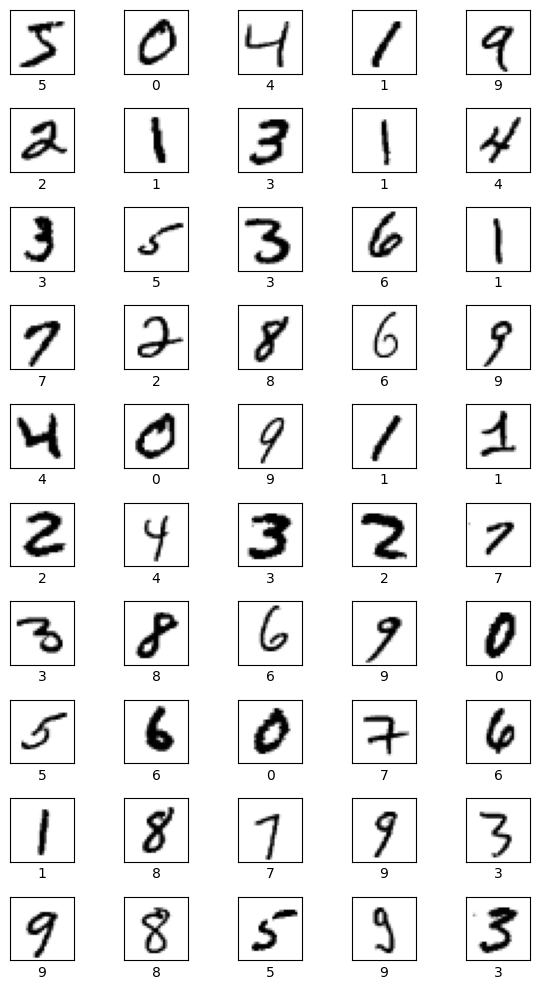

In [3]:
plt.figure(figsize=(6,10))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.tight_layout()

## Preparación de los datos: escalado

Los datos crudos casi nunca se usan directamente. Aquí realizamos dos pasos de preprocesamiento esenciales:

- **Normalización**: Las imágenes tienen valores de píxeles de 0 a 255. Al dividir por 255, escalamos todos los valores para que estén en el rango de 0 a 1. Esto ayuda a que el entrenamiento sea más estable y rápido.

- **One-Hot Encoding**: Nuestras etiquetas "y" son números del 0 al 9. Para un problema de clasificación multiclase, convertimos cada etiqueta en un vector de 10 posiciones, donde solo la posición correspondiente a la clase correcta tiene un '1' y el resto son '0's. Por ejemplo, la etiqueta 7 se convierte en [0,0,0,0,0,0,0,1,0,0].

In [4]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices for use with categorical_crossentropy
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## El Modelo: Red Neuronal Convolucional (CNN)

Aquí es donde creamos el "cerebro" de nuestro modelo.

- **keras.Sequential**: Creamos un modelo cuyas capas se apilan una encima de la otra.

- **layers.Conv2D(8, kernel_size=(3, 3), activation="relu")**: Primera capa convolucional con 8 filtros de 3x3 píxeles. Estos filtros aprenden a detectar características básicas como bordes y líneas en las imágenes. Usa `relu` como función de activación.

- **layers.MaxPooling2D(pool_size=(5, 5))**: Otra reducción de dimensiones para concentrar la información relevante.

- **layers.Flatten()**: Convierte los mapas de características 2D en un vector plano de números para poder conectarlo con capas densas.

- **layers.Dense(num_classes, activation="softmax")**: Capa de salida con 10 neuronas (una para cada dígito del 0 al 9). Usa `softmax` para convertir las salidas en probabilidades que suman 1.

In [5]:
# CÓDIGO A OPTIMIZAR
from keras import layers, models, optimizers

# --- CÓDIGO FASE 0 (INICIO EXAMEN) ---
model = models.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

E0000 00:00:1768404083.180478    6027 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1768404083.192396    6027 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Antes de entrenar, debemos "compilar" el modelo. Esto es como darle al motor las instrucciones finales:

- **loss**: Le decimos qué función de error usar. **categorical_crossentropy** (Log Loss) es la correcta para nuestra clasificación multiclase con etiquetas one-hot.

- **optimizer**: Elegimos el algoritmo que ajustará los pesos. Adam es un optimizador robusto y una excelente elección por defecto.

- **metrics**: Le pedimos que, además de la pérdida, nos informe sobre la accuracy (exactitud) durante el entrenamiento.

In [6]:
# CÓDIGO DEL BECARIO A OPTIMIZAR
# --- CÓDIGO FASE 0 (INICIO EXAMEN) ---

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

## Visualizar nuestra ANN

El método .summary() es una herramienta fantástica para verificar la arquitectura de nuestra red. Nos muestra cada capa, su forma de salida y, lo más importante, el número de parámetros (pesos y sesgos) que el modelo necesita aprender.

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento de la red neuronal

Con el método .fit(), iniciamos el proceso de aprendizaje.

- **batch_size**: Le decimos que aprenda en lotes de 128 imágenes.

- **epochs**: Le pedimos que recorra el set de entrenamiento completo 20 veces.

- **validation_split**: Le indicamos que separe automáticamente un 20% de los datos de entrenamiento para usarlos como "examen de práctica" (val_loss) al final de cada época. El resultado del entrenamiento se guarda en el objeto history.

In [8]:
%%time

# CÓDIGO A OPTIMIZAR
# --- CÓDIGO FASE 0 (INICIO EXAMEN) ---
batch_size = 128
epochs = 15

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5
    ),
]
history = model.fit(x_train, y_train, 
                    batch_size       = batch_size, 
                    epochs           = epochs, 
                    validation_split = 0.2,
                    verbose=1, callbacks=callbacks)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.9002 - loss: 0.3169 - val_accuracy: 0.9820 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9716 - loss: 0.0998 - val_accuracy: 0.9852 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9785 - loss: 0.0745 - val_accuracy: 0.9898 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9822 - loss: 0.0600 - val_accuracy: 0.9884 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9874 - loss: 0.0428 - val_accuracy: 0.9918 - val_loss: 0.0325 - learning_rate: 5.0000e-04
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9885 - loss: 0.0377 - val_accuracy: 0.9924 - val_loss: 0.0298 - learning_rate: 5.0000e-04
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.

## Evaluación final de rendimiento

Una vez que el modelo ha sido entrenado, lo evaluamos con el conjunto de test. Estos son datos que el modelo nunca ha visto. El resultado de .evaluate() nos da la medida más honesta de qué tan bien generaliza nuestro modelo.

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy en el Test set:", score[1]) # ESTO DEFINE TU ACCURACY OBJETIVO, DEBES COMPARAR TU PROGRESO CONTRA ESTE VALOR

Accuracy en el Test set: 0.9933000206947327


## Curvas de aprendizaje

El objeto history contiene la historia completa del entrenamiento. Al graficar el loss y el val_loss (y el accuracy y val_accuracy) a lo largo de las épocas, podemos visualizar la "historia de dos curvas" y diagnosticar si nuestro modelo ha aprendido bien o si ha sufrido de sobreajuste ('overfitting').

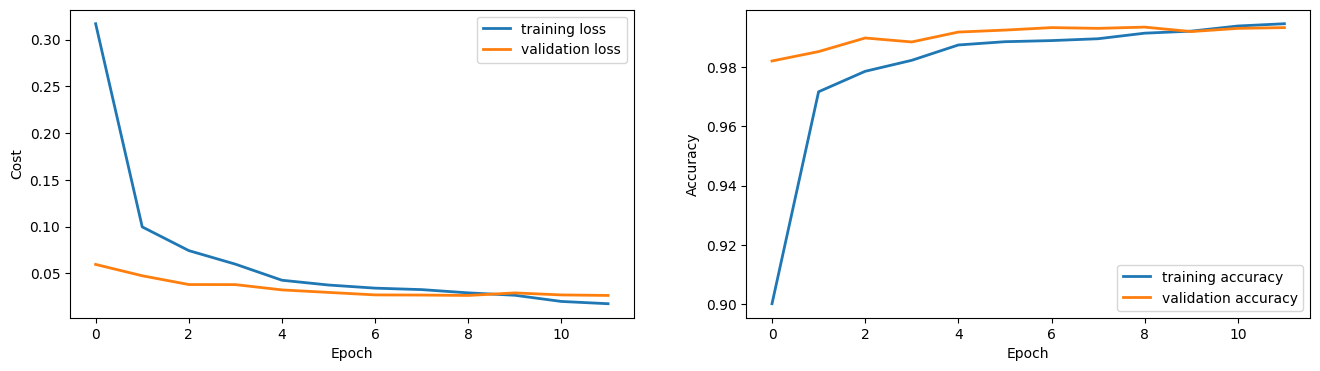

In [10]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[:,"accuracy"], lw=2, label='training accuracy')
plt.plot(logs.loc[:,"val_accuracy"], lw=2, label='validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

## Matriz de Confusión

El accuracy nos dice cuántas veces acertó el modelo, pero no nos dice en qué se equivocó. La matriz de confusión es una herramienta visual que nos muestra exactamente qué clases el modelo tiende a confundir. Por ejemplo, ¿confunde a menudo los '8's con los '9's?
Para crearla, primero usamos **.predict()** para obtener las probabilidades y **np.argmax()** para convertirlas en la clase predicha.

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


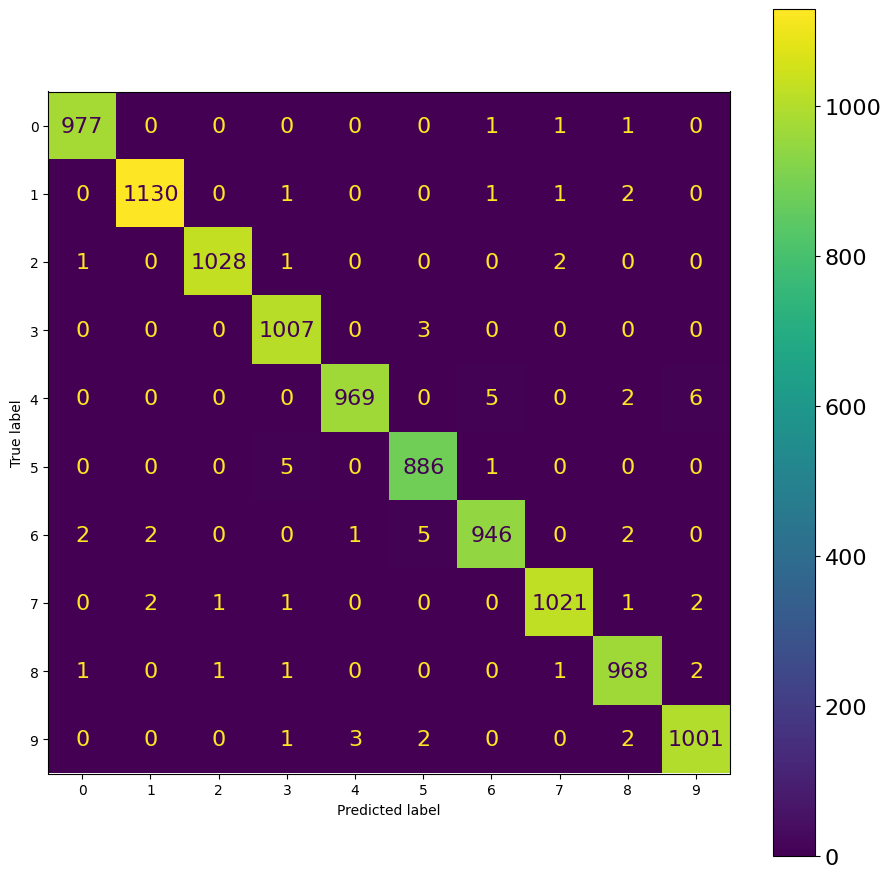

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Predecimos las clases para el conjunto de test
y_prediction = model.predict(x_test)
# Convertimos las probabilidades a la clase con mayor probabilidad
y_pred_classes = np.argmax(y_prediction, axis = 1) 
# Convertimos las etiquetas one-hot del test set a su valor original
y_true = np.argmax(y_test, axis = 1) 

# Creamos y visualizamos la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(11,11))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.rcParams.update({'font.size': 16})
disp.plot(ax=ax);